<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/Majority_Voting1/MV_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subclassing for GS

In [ ]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [ ]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        elif self.optimizer == "RMSprop":
            opt = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        elif self.optimizer == "Adagrad":
            opt = tf.keras.optimizers.Adagrad(learning_rate=self.learning_rate)
        else:
            opt=self.optimizer

            #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        input_l_b = tf.keras.layers.BatchNormalization()(input_l)        
        input_l_do = tf.keras.layers.Dropout(rate=self.dropout)(input_l_b)    
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*1.5*(self.K+self.R)),activation='selu',name='h1', 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l_do)#argumento de entrada
        #h1 = tf.keras.layers.BatchNormalization()(h1)        
        h1 = tf.keras.layers.Dropout(rate=self.dropout)(h1)      
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        #h2 = tf.keras.layers.BatchNormalization()(h2)     
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics="accuracy")
         
            
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose, shuffle=True)
 
        return self
 
       
    def model_MC(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
        return  self.model(X, training=True) 
 
  
   
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [ ]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2023-02-09 03:32:41--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 74.125.68.138, 74.125.68.101, 74.125.68.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.68.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4ap06l2n7jr89o9psam5decifgd83mn6/1675913550000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=7ef3f3fe-e43c-4c21-b916-611bd5413b37 [following]
--2023-02-09 03:32:42--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4ap06l2n7jr89o9psam5decifgd83mn6/1675913550000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=7ef3f3fe-e43c-4c21-b916-611bd5413b37
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 142.250.4.132, 2404:

# Load Data

In [ ]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Music' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


path_ = 'MADatasets/'+ database+ '.mat' 
Xdata = sio.loadmat(path_)
Xdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xtest', 'Xtrain', 'Ytrain', 'vRef', 'ytest', 'ytrain'])

In [ ]:

Xtrain = Xdata['Xtrain']
Xtest = Xdata['Xtest']
Y_train =  Xdata['Ytrain']
vref =  Xdata['vRef']

Y_true_train= Xdata['ytrain'].reshape(-1)
Y_true_test  = Xdata['ytest'].reshape(-1)
print('Xtrain',Xtrain.shape, 'Xtest',Xtest.shape,  'Y_true_train', Y_true_train.shape, 'Y_train',Y_train.shape, 'Y_true_test',Y_true_test.shape)
  
 

Xtrain (700, 124) Xtest (300, 124) Y_true_train (700,) Y_train (700, 44) Y_true_test (300,)


In [ ]:
import numpy as np
from scipy import stats
Ytr_mv  = []

for i in range(Y_train.shape[0]):
     #print(Y_train[i])
     Ytr_mv   += [np.take(stats.mode(Y_train[i,Y_train[i] != -1.e+20]),0)]
     #print(mode_Y)
#Ytr_mv 

In [ ]:
Ytr_mv = np.array(Ytr_mv )

# Split data

In [ ]:
 
N = Y_true_train.shape[0]
Nk = 1
Ntr = round(N)
train_index = np.zeros((Ntr))
rng = np.random.default_rng(seed=123)
 
aux = rng.permutation(N, axis=0)
train_index = aux[0:Ntr]
print(train_index.shape)

 
X_train, Y_train = Xtrain[train_index,:], Ytr_mv[train_index]
Y_true_train = Y_true_train[train_index].reshape(-1,1)
train_index

(700,)


array([ 64, 404, 641, 400,   9, 321, 458, 151, 287, 689, 535, 699, 494,
       499, 460, 413, 587,  51, 492, 234,  54, 175, 238, 359,  10, 670,
        96,  13, 329, 520,  94, 199, 442, 319, 679, 289, 654, 463,  76,
       471, 212, 401, 402,  43, 274, 337, 348, 567, 639, 551, 547, 617,
       382, 515, 286, 305, 443, 544, 370, 488, 323, 207, 288, 230, 555,
       198,  36, 481, 398,   4, 342, 495, 486, 446, 114, 678, 134, 125,
       432, 550, 275, 185, 657, 137, 293, 562,  97, 478, 627, 386, 415,
        78, 484, 614,  57, 225, 192, 642, 390,  31, 222, 336,  19, 239,
        56, 130, 221, 462, 202, 613, 171, 447, 191, 360,  16, 211, 394,
       621, 563, 695, 646, 663, 389, 554, 373, 680,  30, 150, 561, 656,
       475, 284, 611, 354, 668, 263, 676, 684, 553, 278, 630, 669, 594,
       218, 309,  21, 565, 514, 372, 560, 452, 273, 308, 371, 582, 482,
       606, 109, 294, 522, 383, 575,  95, 327, 368, 176, 615, 158, 392,
       418, 143, 167, 479, 129, 517, 533, 546, 503, 111,  23, 34

In [ ]:
N = Y_true_test.shape[0]
Nk = 1
Nte = round(N)
test_index = np.zeros((Nte))
#test_index = np.zeros((N-Ntr))
rng = np.random.default_rng( seed=123)
#for i in range(Nk):
    
aux = rng.permutation(N, axis=0)
#print(aux)
test_index = aux[0:Nte]
#print(idxtr)
#test_index= aux[Ntr+1:] 
print(test_index.shape)

  
X_test = Xtest[test_index,:]
Y_true_test = Y_true_test[test_index].reshape(-1,1)
test_index

(300,)


array([273, 192, 169, 162,  91, 120,  38, 251, 195,  65, 290, 249,  99,
       296,  46, 239, 258,  72, 134, 189, 116,  53, 280, 246, 205, 247,
       113,  87, 151, 278, 240,  80,  18,  54, 129, 245, 132,   2, 196,
       283, 202, 224, 145, 130, 263,  74,  52, 127, 104, 126, 212,  51,
       241, 235, 250,  31, 262,  95,   9, 138, 114,  28, 101, 238,  41,
       185,  60, 167, 259, 161,  43, 256, 204, 163, 265, 157,  45, 203,
       217, 140, 277, 171,  16, 109,  84, 223,  23,  35, 260, 257, 267,
        90, 270, 103, 284,  39,  50, 184, 170, 287,  79, 194, 292, 123,
       227, 122, 148, 188, 299,  48, 210, 264, 117,  15, 176, 165,  63,
        56, 106,  85, 197,  69, 166, 154, 295,  96, 220, 248,  42, 175,
       146, 115,   1, 293, 206, 172, 215,  97,  83, 281, 275, 159,  14,
       218, 234, 160, 236, 213, 181, 143, 102,  49,  34, 180,  86,  77,
       242, 279,  21, 211,  81, 269, 186, 229, 298, 193, 252,  62, 230,
        11, 111, 128, 131,  75,   4,   8, 208,  37,  19, 182,  2

In [ ]:
Y_train = Y_train-1
Y_true_train = Y_true_train-1
Y_true_test = Y_true_test -1

Text(0, 0.5, 'Frequency')

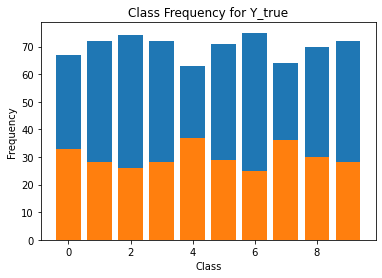

In [ ]:

unique, counts = np.unique(Y_true_train, return_counts=True)
plt.figure()
plt.bar(unique, counts)
unique, counts = np.unique(Y_true_test, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency for Y_true')
plt.xlabel('Class')
plt.ylabel('Frequency')

In [ ]:
# for i in range(Y.shape[1]):
#     print('annotator',i+1)
   
#     unique, counts = np.unique(Y_train[:,i], return_counts=True)
#     plt.figure()
#     plt.bar(unique, counts)
#     unique, counts = np.unique(Y_test[:,i], return_counts=True)
#     plt.bar(unique, counts)

#     plt.title('Class Frequency for Y_true')
#     plt.xlabel('Class')
#     plt.ylabel('Frequency')


# Apply MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
 
from sklearn.linear_model import LogisticRegression
#scaler = preprocessing.StandardScaler().fit(X_train)
clf = LogisticRegression(random_state=0).fit(X_train, Y_true_train.ravel())
 
clf.score(X_test, Y_true_test.ravel())


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.71

# Testing the Class 


iteration: 0


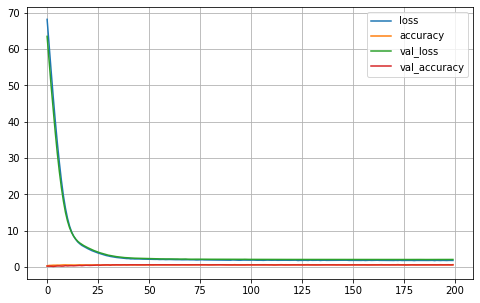

10/10 [==============================] - 0s 2ms/step
Validation ACC: 0.6300
Validation Balanced_ACC: 0.5782
Validation MI: 1.2478
Validation Normalized MI: 0.5538
Validation Adjusted MI: 0.5223
Validation aUc: 0.7209
Validation aUc_Sklearn: 0.9382
iteration: 1


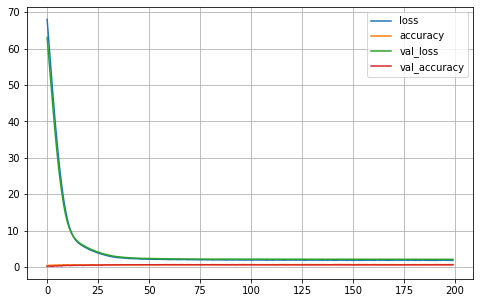

10/10 [==============================] - 0s 2ms/step
Validation ACC: 0.6367
Validation Balanced_ACC: 0.5851
Validation MI: 1.2196
Validation Normalized MI: 0.5392
Validation Adjusted MI: 0.5065
Validation aUc: 0.6830
Validation aUc_Sklearn: 0.9338
iteration: 2


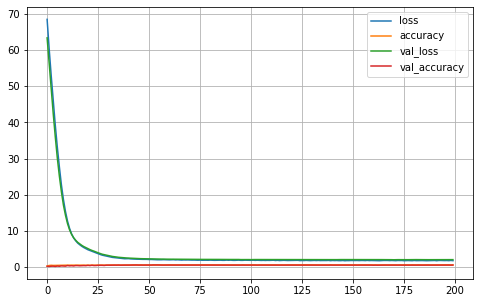

10/10 [==============================] - 0s 3ms/step
Validation ACC: 0.6433
Validation Balanced_ACC: 0.5959
Validation MI: 1.2778
Validation Normalized MI: 0.5681
Validation Adjusted MI: 0.5375
Validation aUc: 0.6790
Validation aUc_Sklearn: 0.9337
iteration: 3


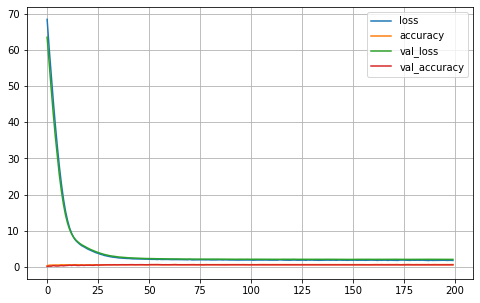

10/10 [==============================] - 0s 2ms/step
Validation ACC: 0.6333
Validation Balanced_ACC: 0.5833
Validation MI: 1.2234
Validation Normalized MI: 0.5450
Validation Adjusted MI: 0.5128
Validation aUc: 0.6571
Validation aUc_Sklearn: 0.9326
iteration: 4


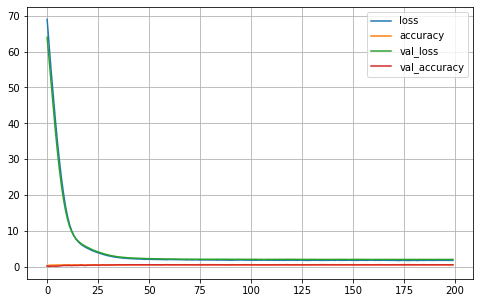

10/10 [==============================] - 0s 2ms/step
Validation ACC: 0.6267
Validation Balanced_ACC: 0.5740
Validation MI: 1.1951
Validation Normalized MI: 0.5299
Validation Adjusted MI: 0.4961
Validation aUc: 0.7588
Validation aUc_Sklearn: 0.9378
iteration: 5


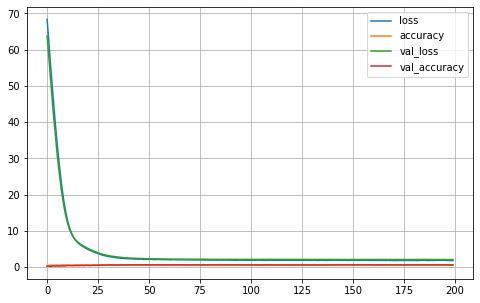

10/10 [==============================] - 0s 2ms/step
Validation ACC: 0.6233
Validation Balanced_ACC: 0.5706
Validation MI: 1.2118
Validation Normalized MI: 0.5383
Validation Adjusted MI: 0.5054
Validation aUc: 0.6837
Validation aUc_Sklearn: 0.9374
iteration: 6


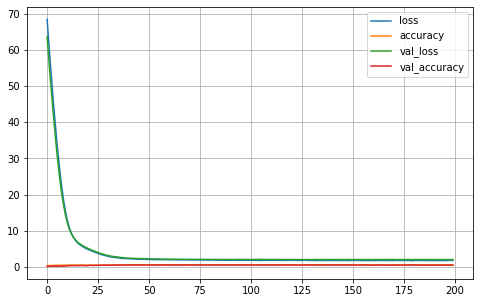

10/10 [==============================] - 0s 3ms/step
Validation ACC: 0.6367
Validation Balanced_ACC: 0.5875
Validation MI: 1.2347
Validation Normalized MI: 0.5440
Validation Adjusted MI: 0.5116
Validation aUc: 0.7245
Validation aUc_Sklearn: 0.9363
iteration: 7


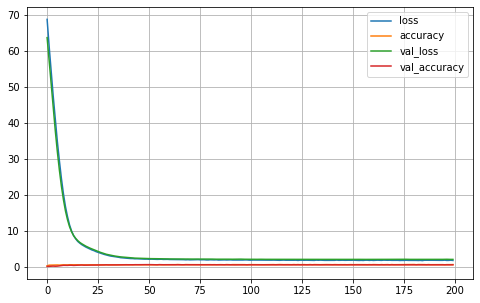

10/10 [==============================] - 0s 2ms/step
Validation ACC: 0.6067
Validation Balanced_ACC: 0.5523
Validation MI: 1.1609
Validation Normalized MI: 0.5147
Validation Adjusted MI: 0.4802
Validation aUc: 0.7209
Validation aUc_Sklearn: 0.9332
iteration: 8


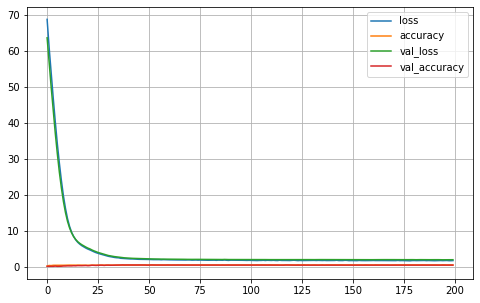

10/10 [==============================] - 0s 2ms/step
Validation ACC: 0.6300
Validation Balanced_ACC: 0.5819
Validation MI: 1.1743
Validation Normalized MI: 0.5185
Validation Adjusted MI: 0.4841
Validation aUc: 0.7320
Validation aUc_Sklearn: 0.9378
iteration: 9


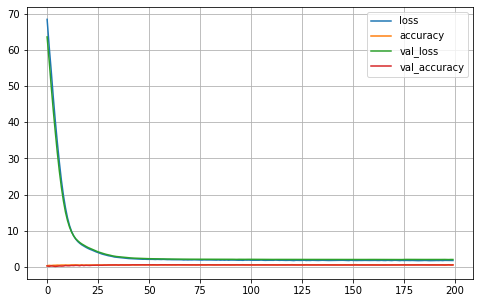

10/10 [==============================] - 0s 2ms/step
Validation ACC: 0.6133
Validation Balanced_ACC: 0.5584
Validation MI: 1.2018
Validation Normalized MI: 0.5351
Validation Adjusted MI: 0.5021
Validation aUc: 0.7197
Validation aUc_Sklearn: 0.9366


In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score,roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =0.001
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
   
    MA = Keras_MA_GCCE(epochs=200,batch_size=64,R=1, K=len(np.unique(Y_true_train)), dropout=0.25, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  verbose=0, q=0.1) #, neurons=.5)

    MA.fit(X_train,Y_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))


    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC

    val_AUC1 = roc_auc_score(ook(Y_true_test), pred_2)
    print("Validation aUc_Sklearn: %.4f" % (float(val_AUC1),))
    AUC[i] = val_AUC1

    

    # y_model = MA.model_MC(X_test)
    # y_model = y_model
    # y_probas = np.stack([y_model # se activa training en True para que el Dropout se aplique
    #                     for sample in range(100)])
    # y_proba = y_probas.mean(axis=0)
    # y_std = y_probas.std(axis=0)
    # y_pred = np.argmax(y_proba, axis=1)

    # from sklearn.metrics import accuracy_score
    # accuracy_score(Y_true_test, y_pred)
    # print("Validation  montecarlo ACC: %.4f" % (float(accuracy_score(Y_true_test, y_pred)),))


    # #AUC ================================================================================
    # val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
    # #val_logits =MA.predict(X_test) # model(X_test, training=False)
    # # tf.print(y_batch_val)
    # val_AUC_metric.update_state(Y_true_test, y_pred.astype('float'))

    # val_AUC = val_AUC_metric.result()
    # val_AUC_metric.reset_states()
    # val_AUC = val_AUC.numpy()
    # print("Validation montecarlo aUc: %.4f" % (float(val_AUC),))

In [ ]:
ACC

array([0.63      , 0.63666667, 0.64333333, 0.63333333, 0.62666667,
       0.62333333, 0.63666667, 0.60666667, 0.63      , 0.61333333])

In [ ]:

AUC

array([0.93820953, 0.93377253, 0.933681  , 0.93264428, 0.93783448,
       0.93743647, 0.93631185, 0.93322195, 0.93776427, 0.93664858])

# Metrics Results

In [ ]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  62.8
Average std:  1.06
Average AUC:  93.58
Average AUC std:  0.21
Average Balanced Accuracy:  57.67
Average std:  1.27
Average MI:  121.46999999999998
Average std:  3.27
Average Normalized MI:  53.87
Average std:  1.49
Average Ajdusted MI:  50.580000000000005
Average std:  1.6099999999999999
